In [40]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

dir = '/Users/mrefermat/git/FinancePhD/Empirical Methods/Homework2/'

file1 = 'CRSPzero_yields.xls'
file2 = 'GDPC1.xls'
file3 = 'Factors(1).xlsx'
file4 = 'FoF.xlsx'
file5 = 'tbill.csv'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [58]:
tbill=pd.read_csv(dir+file5,parse_dates=0,index_col=0).resample(rule='m',how='last')
factors=pd.read_excel(dir+file3,parse_dates=0,header=4,index_col=0).resample(rule='m',how='last')
FoF=pd.read_excel(dir+file4,parse_dates=0,index_col=0).resample(rule='m',how='last')

Since we use excess returns in the regression, we need to take away 30 day cash returns.

In [59]:
FoF=FoF-tbill.t30ret*100

In [60]:
beta=pd.DataFrame()
t_stats=pd.DataFrame()
p_values=pd.DataFrame()
r2= pd.Series()
for f in FoF.columns:
    df = pd.DataFrame()
    df['Fund']=FoF[f].dropna()
    if df.Fund.count() < 60:
        continue
    df=pd.concat([df,factors],axis=1, join='inner')
    df['Alpha']=1
    cols= factors.columns.tolist()
    cols.append('Alpha')
    res = sm.OLS(df.Fund,df[cols]).fit()
    beta[f]=res.params
    t_stats[f]=res.tvalues
    p_values[f]=res.pvalues
    r2[f]=res.rsquared

In [61]:
beta.T.mean()

Equity market factor       -3.441294
Size Spread factor          0.394232
Bond market factor         27.569260
Credit Spread factor     -189.273722
PTFSBD                     -0.390284
PTFSFX                      0.282721
PTFSCOM                     0.570708
Emerging Market factor     15.179668
Alpha                      -0.010674
dtype: float64

In [62]:
t_stats.T.mean()

Equity market factor     -0.551242
Size Spread factor        0.160711
Bond market factor        0.306786
Credit Spread factor     -2.291481
PTFSBD                   -0.432450
PTFSFX                    0.245363
PTFSCOM                   0.378847
Emerging Market factor    4.043323
Alpha                     0.606405
dtype: float64

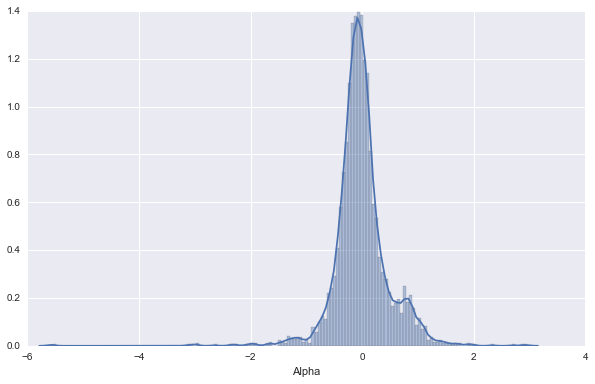

In [63]:
sns.distplot(beta.T.Alpha)

# T stat distribution
Note how high some of the alpha terms are

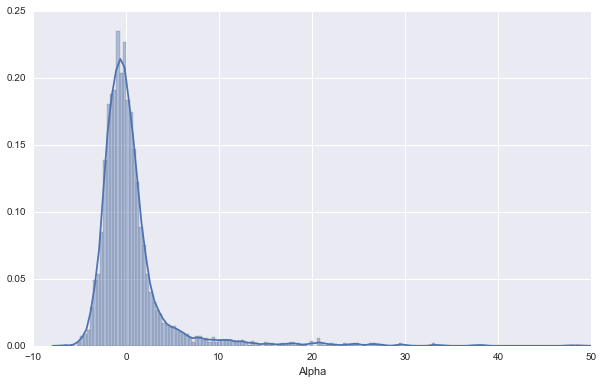

In [64]:
sns.distplot(t_stats.T.Alpha)

# p value distribution

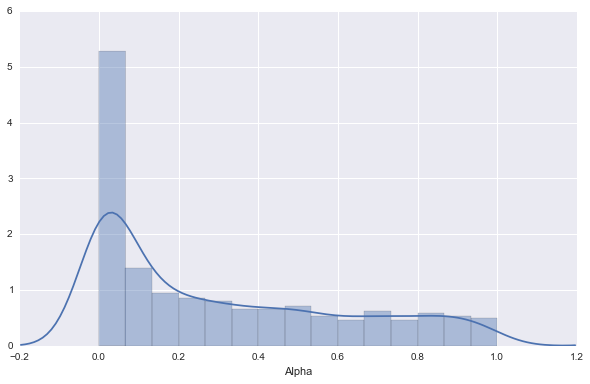

In [65]:
sns.distplot(p_values.T.Alpha)

To estimate $\pi_0$, we need to pick an threshold, $\lambda_0$, and then work out the proportion of funds that above the threshold.  The formula for calculting $\hat{\pi_0}$ is:

$$ \hat{\pi_0} = \frac{\hat{W}(\lambda^*)}{M} \frac{1}{1-\lambda^*} $$

We can apply a simple bootstrap procedure to minimize the estimated mean squared error (MSE) of $\hat{\pi_0}$ in order to select the best $\lambda^*$.  Where $\hat{W}(\lambda^*)$ is the proportion with p values exceeding $\lambda^*$.

In [66]:
# Code from: http://nbviewer.jupyter.org/gist/aflaxman/6871948
# randomly resamples Series and returns it
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if isinstance(X, pd.Series):
        X = X.copy()
        X.index = range(len(X.index))
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = np.array(X[resample_i])  # TODO: write a test demonstrating why array() is important
    return X_resample


First calcuate $\hat{\pi_0}$ for each value of $\lambda$ from 0.3 to 0.7 in increments of 0.05. in this equation:

$$ \hat{\pi_0} = \frac{\hat{W}(\lambda^*)}{M} \frac{1}{1-\lambda^*} $$

In [67]:
# Calculating lambda * and pi hat using bootstraping 
pv=p_values.T.Alpha
min_pi_hat=1
for lamb in [x / 100. for x in range(30,75,5)]:
    if min_pi_hat > pv[pv>lamb].count() / float(pv.count()) * 1/(1-lamb):
        min_pi_hat = pv[pv>lamb].count() / float(pv.count()) * 1/(1-lamb)

d={}
for lamb in [x / 100. for x in range(30,75,5)]:
    l=[]
    for x in range(0,1000):
        bsr = bootstrap_resample(pv)
        l.append(((bsr>lamb).sum() / float(len(bsr)) * 1/(1-lamb)-min_pi_hat)**2)
    d[lamb]=np.mean(l)
lambda_star=min(d, key=d.get)
print 'Lambda*: '+ str(lambda_star)
# Calculating pi hat using lambda *
pi_hat = pv[pv>lambda_star].count() / float(pv.count()) * 1/(1-lambda_star)
print 'Pi_0^hat: '+ str(pi_hat)

Lambda*: 0.55
Pi_0^hat: 0.524561969257


To determine the value for $\gamma^*$, we use bootstrapping techniques to minimizes the estimated MSE of $\hat{\pi_A^-}(\gamma).  

$$ \hat{MSE}^-(\gamma) = \frac{1}{1000}\sum_{b=1}^{1000} \left [ \hat{\pi}_A^{b-}(\gamma) - \max_{\gamma}\hat{\pi}_A^-(\gamma) \right ]^2 $$

where:

$$ \hat{\pi}_A^- = \hat{S}_\gamma^- - \hat{\pi}_0 * \gamma /2$$

In [68]:
# Calculating gamma * via the bootstrapping methodology
alpha_t_stat=t_stats.T.Alpha
max_pi_hat=0
for gamma in [x / 100. for x in range(1,55,2)]:
    thres = stats.t.ppf(1-(gamma/200.),999)*-1   
    signif=alpha_t_stat[alpha_t_stat<thres].count() / float(alpha_t_stat.count())
    print signif-pi_hat*gamma/2.0
    if max_pi_hat < signif-pi_hat*gamma/2.0:
        max_pi_hat = signif-pi_hat*gamma/2.0
        



0.0080189186284
0.00793292486295
0.00945931419972
0.00808341395249
0.00638503708481
0.00275180049446
-0.000558959475438
-0.00290228958401
-0.00524561969257
-0.00920133290336
-0.0131570461142
-0.0164678060841
-0.0191336128131
-0.0234118026443
-0.0276899924755
-0.0322906589272
-0.0365688487585
-0.0414919918306
-0.0457701816618
-0.0500483714931
-0.0549715145652
-0.0592497043964
-0.0635278942277
-0.0684510372998
-0.072729227131
-0.0763624637214
-0.0803181769322


In [69]:
beta.T.Alpha[alpha_t_stat>0].count()/float(alpha_t_stat.count())

0.43502096098032894